# ***SVC***

In [1]:
import os
import time
import joblib
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.svm import SVC
from sklearn.metrics import (
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, log_loss, roc_auc_score, roc_curve, auc
)
import optuna
from optuna.pruners import MedianPruner
import optuna.visualization as vis
import plotly.graph_objects as go
import lime.lime_tabular

from reporte_metricas import ReporteMetricas
reporte = ReporteMetricas()

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
# =======================
# LOAD DATA
# =======================
file_path = "../Preprocessed_data.xlsx"
df = pd.read_excel(file_path)
X = df.drop(columns=["Cuenta", "Estado", "ID"])
y = df["Estado"]

categorical_features = X.select_dtypes(include='object').columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [3]:
# ============================
# FILE PATHS
# ============================
model_filename = "../Models/best_svc_model.pkl"
study_filename = "../Study/optuna_study_SVC_nested.pkl"
metrics_filename = "../Models/best_svc_metrics.pkl"
fold_metrics_filename = "./Metrics/svc_folds_summary.csv"

In [4]:
# ============================
# MODEL PIPELINE BUILDER
# ============================
def build_pipeline(params: dict, numeric_features: list, categorical_features: list):
    preprocessor = ColumnTransformer([
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="Sin Dato")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), categorical_features)
    ], 
    verbose_feature_names_out=False,
    force_int_remainder_cols = False
    )
    

    model = SVC(**params, probability=True, random_state=SEED)
    return Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])

In [5]:
# ============================
# MODEL EVALUATION
# ============================
def evaluate_model(model, X_data, y_data):
    y_pred = model.predict(X_data)
    y_proba = model.predict_proba(X_data)
    f1 = f1_score(y_data, y_pred, average='weighted')
    acc = accuracy_score(y_data, y_pred)
    loss = log_loss(y_data, y_proba)
    auc = roc_auc_score(y_data, y_proba, multi_class='ovr', average='weighted')
    report = classification_report(y_data, y_pred)
    cm = confusion_matrix(y_data, y_pred)
    return f1, acc, loss, auc, report, cm, y_proba, y_pred

# ============================
# CONFUSION MATRIX PLOTTER
# ============================
def plot_confusion_matrix(cm, labels, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")
    disp.ax_.set_title(title)

In [6]:
# ============================
# OPTUNA INNER CV OPTIMIZATION
# ============================
def run_inner_optuna(X_inner, y_inner, numeric_features, categorical_features, n_trials=50):
    def objective(trial):
        kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])

        params = {
            "C": trial.suggest_float("C", 1e-3, 100.0, log=True),
            "kernel": kernel,
            "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),
            "degree": trial.suggest_int("degree", 2, 5) if kernel == "poly" else 3,
        }

        model = build_pipeline(params, numeric_features, categorical_features)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
        scores = []

        for train_idx, val_idx in skf.split(X_inner, y_inner):
            X_t, X_v = X_inner.iloc[train_idx], X_inner.iloc[val_idx]
            y_t, y_v = y_inner.iloc[train_idx], y_inner.iloc[val_idx]
            sample_weights = compute_sample_weight("balanced", y_t)
            model.fit(X_t, y_t, classifier__sample_weight=sample_weights)
            y_pred = model.predict(X_v) 
            scores.append(f1_score(y_v, y_pred, average='weighted'))

        return np.mean(scores)

    study = optuna.create_study(direction="maximize", pruner=MedianPruner())
    study.optimize(objective, n_trials=n_trials, n_jobs=4)
    return study.best_params, study

In [7]:
# ============================
# SAVE FOLD METRICS
# ============================
def save_metrics_folds(folds_metrics: list, filename: str):
    df = pd.DataFrame(folds_metrics)
    resumen = df.describe().T[['mean', 'std']].reset_index()
    resumen.rename(columns={'index': 'metric'}, inplace=True)
    df_full = pd.concat([df, resumen], axis=0)
    df_full.to_csv(filename, index=False)
    return df, resumen

In [8]:
# ============================
# LIME EXPLAINER BUILDER
# ============================
def get_lime_explainer(model_pipeline, X_train_raw, y_train_raw):
    X_transformed = model_pipeline.named_steps['preprocessor'].transform(X_train_raw)
    feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
    class_names = np.unique(y_train_raw).astype(str)
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_transformed,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification'
    )
    return explainer, X_transformed

In [9]:
# ============================
# NESTED CV LOOP
# ============================
def nested_cv(X, y, numeric_features, categorical_features):
    visualizations = {}
    all_folds_metrics = []

    if os.path.exists(model_filename) and os.path.exists(metrics_filename):
        best_model = joblib.load(model_filename)
        best_metrics = joblib.load(metrics_filename)
        if "best_fold" in best_metrics:
            study_dt = joblib.load(study_filename)['studies'][best_metrics['best_fold']]
        else:
            study_dt = None
        if study_dt:
            visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
            visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
            visualizations['param_importances'] = vis.plot_param_importances(study_dt)
            f1_scores = [t.value for t in study_dt.trials]
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
            fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
            visualizations['f1_score_evolution'] = fig
        return best_model, best_metrics, study_dt, visualizations

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    best_model, best_metrics = None, {}
    best_f1 = -np.inf
    optuna_studies = []
    best_fold = 1

    for fold, (train_idx, test_idx) in tqdm(
        enumerate(outer_cv.split(X, y), 1),
        total=outer_cv.get_n_splits(),
        desc = "Training folds"
    ):
        
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        X_tr, X_val, y_tr, y_val = train_test_split(
                X_train_fold, y_train_fold,
                test_size=0.2, stratify=y_train_fold, random_state=SEED)

        start_time = time.time()
        best_params, study = run_inner_optuna(X_tr, y_tr, numeric_features, categorical_features)
        elapsed = time.time() - start_time
        optuna_studies.append(study)

        model = build_pipeline(best_params, numeric_features, categorical_features)
        model.fit(X_tr, y_tr)

        f1_train, acc_train, loss_train, auc_train, report_train, cm_train, y_proba_train, y_train_pred = evaluate_model(model, X_tr, y_tr)
        f1_val, acc_val, loss_val, auc_val, report_val, cm_val, y_proba_val, y_val_pred = evaluate_model(model, X_val, y_val)
        f1_test, acc_test, loss_test, auc_test, report_test, cm_test, y_proba_test, y_test_pred = evaluate_model(model, X_test_fold, y_test_fold)

        fold_metrics = {
            "fold": fold,
            "f1_train": f1_train,
            "accuracy_train": acc_train,
            "log_loss_train": loss_train,
            "auc_train": auc_train,
            "f1_val": f1_val,
            "accuracy_val": acc_val,
            "log_loss_val": loss_val,
            "auc_val": auc_val,
            "f1_test": f1_test,
            "accuracy_test": acc_test,
            "log_loss_test": loss_test,
            "auc_test": auc_test,
            "optuna_time": elapsed
        }
        all_folds_metrics.append(fold_metrics)

        if f1_test > best_f1:
            best_f1 = f1_test
            best_model = model
            best_metrics = {
                **fold_metrics,
                "params": best_params,
                "labels": np.unique(y),
                "best_fold": fold - 1,
                "X_train_fold": X_tr,
                "y_train_fold": y_tr,
                "y_train_pred": y_train_pred,
                "y_train_true": y_tr,
                "y_proba_train": y_proba_train,
                "classification_report_train": report_train,
                "confusion_matrix_train": cm_train,
                "y_val_true": y_val,
                "y_val_pred": y_val_pred,
                "y_proba_val": y_proba_val,
                "classification_report_val": report_val,
                "confusion_matrix_val": cm_val,
                "y_test_fold": y_test_fold,
                "y_test_pred": y_test_pred,
                "y_proba_test": y_proba_test,
                "classification_report_test": report_test,
                "confusion_matrix_test": cm_test
            }

    joblib.dump(best_model, model_filename)
    joblib.dump({"studies": optuna_studies}, study_filename)
    joblib.dump(best_metrics, metrics_filename)
    save_metrics_folds(all_folds_metrics, fold_metrics_filename)

    study_dt = optuna_studies[best_metrics['best_fold']]
    visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
    visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
    visualizations['param_importances'] = vis.plot_param_importances(study_dt)

    f1_scores = [t.value for t in study_dt.trials]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
    fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
    visualizations['f1_score_evolution'] = fig

    return best_model, best_metrics, study_dt, visualizations


In [10]:
# Run pipeline
model, metrics, study, visualizations = nested_cv(X, y, numeric_features, categorical_features)

Training folds: 100%|██████████| 5/5 [8:11:24<00:00, 5896.99s/it]  


In [11]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['GRUPO', 'Cupo',
                                                   'dias_mora_Asignacion',
                                                   'saldo_total',
                                                   'Mora_maxima_cliente__Asignacion',
                                                   'situacion', 'Vencto',
                                                   'Priorizacion',
                                                   'Priorizacion_mes_anterior',
                                                   'CONTE...
                                                                                 sparse_output=False))]),
                                                  ['Rango',
                                                   'Tipo_producto_asignacion',
                                                   'FRANJA_REAL_MAX', 'ZONA',
                                                   'Tipo_Normalizacion',
                                                   'Oficina', 'Tipo_Linea_1',
                                                   'Arquetipos',
                                                   'Ultimo_Canal_Gestion',
                                                   'CR_Ultima_Gestion_Cliente',
                                                   'CR_Mejor_Gestion_Cliente',
                                                   'NumeroCuotas'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 SVC(C=7.082014953984712, gamma='auto', probability=True,
                     random_state=42))])

In [12]:
print(metrics['classification_report_train'])

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     13700
           1       0.86      0.74      0.80      4137
           2       0.85      0.73      0.78      2500

    accuracy                           0.90     20337
   macro avg       0.87      0.82      0.84     20337
weighted avg       0.90      0.90      0.89     20337



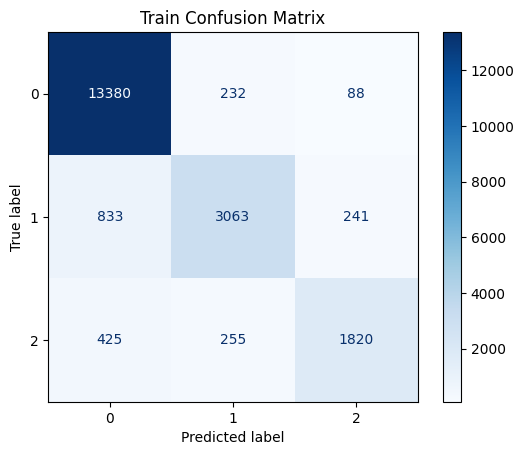

In [13]:
plot_confusion_matrix(metrics['confusion_matrix_train'], metrics['labels'], "Train Confusion Matrix")

In [14]:
print(metrics['classification_report_val'])

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      3426
           1       0.78      0.67      0.72      1034
           2       0.76      0.66      0.71       625

    accuracy                           0.87      5085
   macro avg       0.81      0.76      0.79      5085
weighted avg       0.86      0.87      0.86      5085



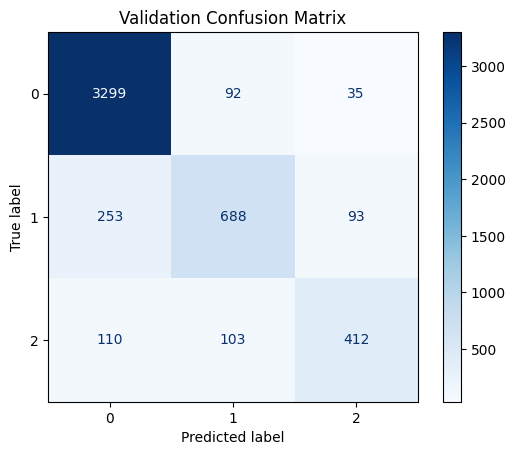

In [15]:
plot_confusion_matrix(metrics['confusion_matrix_val'], metrics['labels'], "Validation Confusion Matrix")

In [16]:
print(metrics['classification_report_test'])

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      4282
           1       0.78      0.68      0.73      1292
           2       0.79      0.63      0.70       781

    accuracy                           0.87      6355
   macro avg       0.82      0.76      0.79      6355
weighted avg       0.86      0.87      0.86      6355



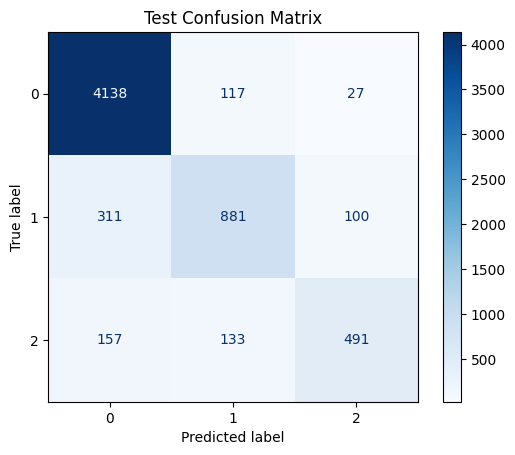

In [17]:
plot_confusion_matrix(metrics['confusion_matrix_test'], metrics['labels'], "Test Confusion Matrix")

--- Explanation for class 0 ---


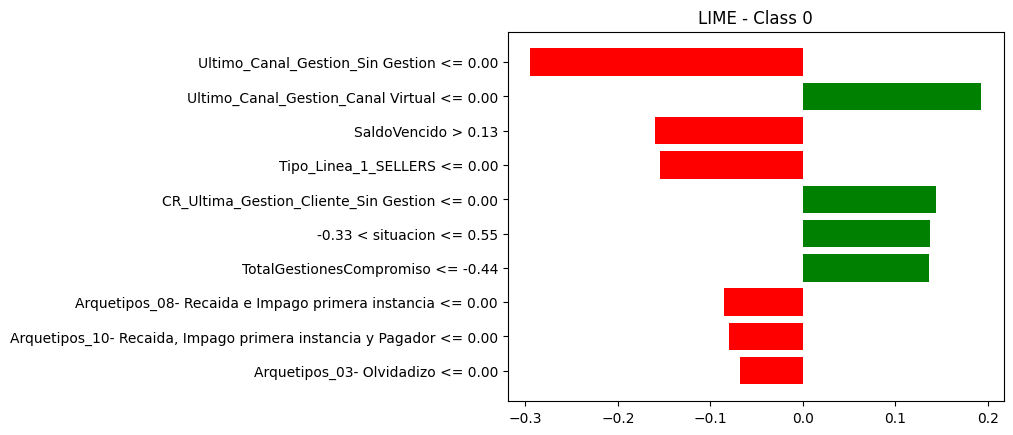

--- Explanation for class 1 ---


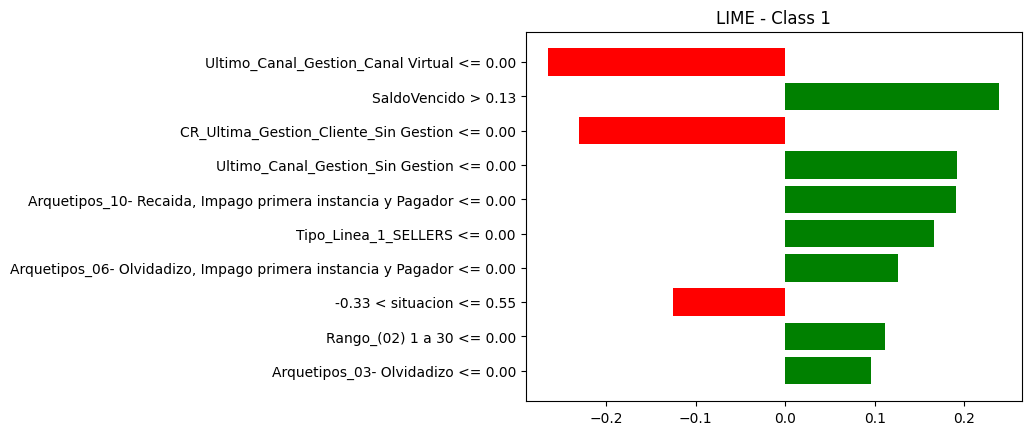

--- Explanation for class 2 ---


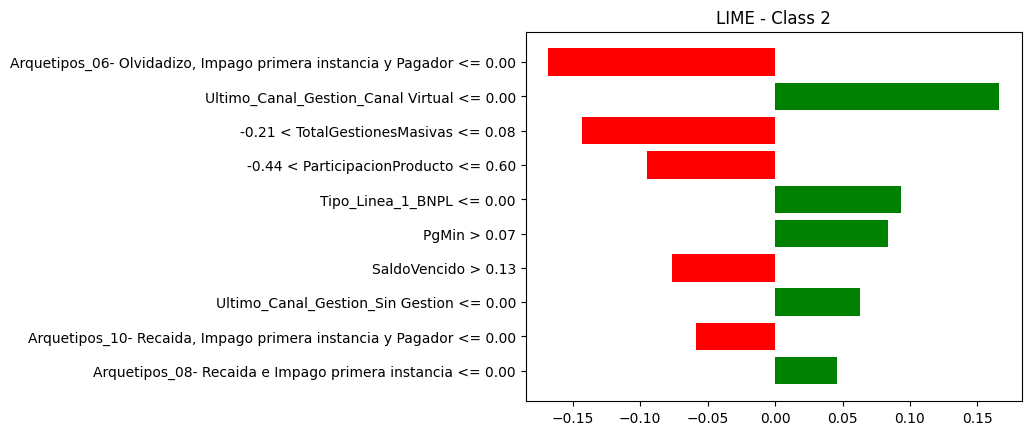

In [18]:
explainer, X_transformed = get_lime_explainer(model, metrics["X_train_fold"], metrics["y_train_fold"])
instance = X_transformed[10]

svc_clf = model.named_steps["classifier"]
predict_fn = lambda x: svc_clf.predict_proba(x)

exp = explainer.explain_instance(instance, predict_fn=predict_fn, labels=[0, 1, 2])
exp.show_in_notebook(show_table=True)

for class_label in exp.available_labels():
    print(f"--- Explanation for class {class_label} ---")
    fig = exp.as_pyplot_figure(label=class_label)
    plt.title(f"LIME - Class {class_label}")
    plt.show()


In [19]:
visualizations['optimization_history']

In [20]:
visualizations['parallel_coordinate']

In [21]:
visualizations['f1_score_evolution']

In [22]:
visualizations['param_importances']

In [23]:
reporte.save(metrics, model_name="SVC")


✅ Report for model 'SVC' saved:
   → CSV: ./Metrics/Metrics_SVC.csv
   → JSON: ./Metrics/Metrics_SVC.json


In [24]:
df = reporte.load()


✅ Loaded 3 report(s):
   → Models: ['RF', 'SVC', 'CART']
   → Types : ['train', 'val', 'test']


In [25]:
df.query("Model == 'SVC' and Type == 'train' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score
18,SVC,train,0,0.914,0.977,0.944
19,SVC,train,1,0.863,0.74,0.797
20,SVC,train,2,0.847,0.728,0.783
21,SVC,train,macro avg,0.875,0.815,0.841
22,SVC,train,weighted avg,0.895,0.898,0.894


In [26]:
df.query("Model == 'SVC' and Type == 'val' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score
24,SVC,val,0,0.901,0.963,0.931
25,SVC,val,1,0.779,0.665,0.718
26,SVC,val,2,0.763,0.659,0.707
27,SVC,val,macro avg,0.814,0.763,0.785
28,SVC,val,weighted avg,0.859,0.865,0.86


In [27]:
df.query("Model == 'SVC' and Type == 'test' and Class != 'global'").iloc[:, 0:6]


,Model,Type,Class,precision,recall,f1-score
30,SVC,test,0,0.898,0.966,0.931
31,SVC,test,1,0.779,0.682,0.727
32,SVC,test,2,0.794,0.629,0.702
33,SVC,test,macro avg,0.824,0.759,0.787
34,SVC,test,weighted avg,0.861,0.867,0.862


In [28]:
df.query("Model == 'SVC' and auc != '-'")[["Model", "Type", "accuracy", "log_loss", "auc"]]


,Model,Type,accuracy,log_loss,auc
23,SVC,train,0.898,0.299,0.965
29,SVC,val,0.865,0.38,0.945
35,SVC,test,0.867,0.374,0.945


In [29]:
df.query("Model == 'SVC' and Type == 'val' and Class	== 'global'")[["Model", "Type", "accuracy", "log_loss", "auc"]]

,Model,Type,accuracy,log_loss,auc
29,SVC,val,0.865,0.38,0.945


In [30]:
def plot_roc_multiclass(y_true, y_proba, class_labels, title="AUC-ROC Curve (Multiclass)"):
    # Binarize true labels
    y_bin = label_binarize(y_true, classes=class_labels)
    n_classes = len(class_labels)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i],
                 label=f"Class {class_labels[i]} (AUC = {roc_auc[i]:.3f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


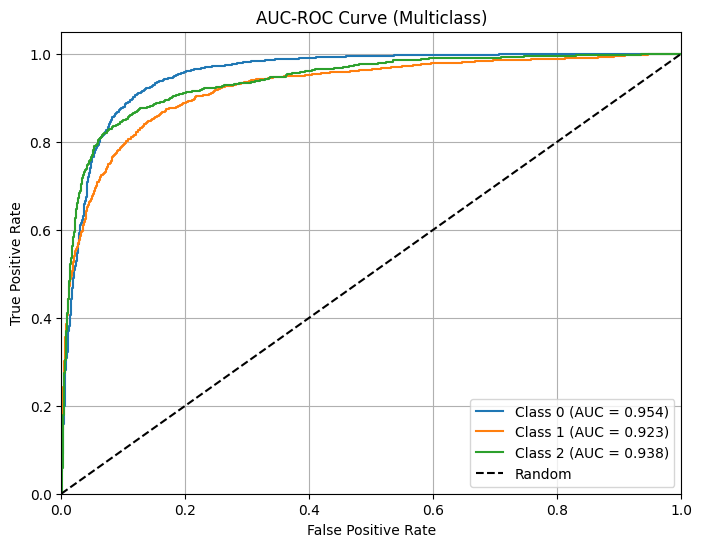

In [31]:
plot_roc_multiclass(
    y_true=metrics["y_test_fold"],
    y_proba=metrics["y_proba_test"],
    class_labels=metrics["labels"]
)

In [32]:
model.named_steps['classifier'].get_params()

{'C': 7.082014953984712,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}